# Jigsaw Multilingual Toxicity Detection
## Ensemble Learning & Analysis

## Στρατηγική Ανάλυσης Δεδομένων

**Pipeline Προεπεξεργασίας**
- Χρήση TfidfVectorizer με 5000 χαρακτηριστικά
- Αφαίρεση stop words

**Μοντελοποίηση**
- Συνδυασμός παραδοσιακών αλγορίθμων Machine Learning
- Εφαρμογή Ensemble τεχνικών
- Στόχος: μέγιστο Recall



## 1. Environment Setup & Data Loading

### Προετοιμασία και Φόρτωση

**Libraries**
- Εισαγωγή βιβλιοθηκών για Machine Learning (sklearn, xgboost)
- Διαχείριση ανισορροπίας δεδομένων με imblearn

**Datasets**
- Φόρτωση των μεταφρασμένων δεδομένων Jigsaw
- Χρήση paths που έχουν οριστεί στα scripts


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

# Φόρτωση Δεδομένων
valid_df = pd.read_csv('../dataset_jigsaw/jigsaw_miltilingual_valid_translated.csv')
test_df = pd.read_csv('../dataset_jigsaw/jigsaw_miltilingual_test_translated.csv')

## 2. Analytic Models Execution & Evaluation

### Εκτέλεση και Αξιολόγηση Μοντέλων

**Baseline Models**
- Εκπαίδευση Naive Bayes
- Linear SVM
- Random Forest
- AdaBoost
- XGBoost

**Recall Focus**
- Χρήση της παραμέτρου scale_pos_weight στο XGBoost
- Βελτίωση του εντοπισμού της τοξικής κλάσης

**Evaluation**
- Παραγωγή classification reports
- Αποθήκευση αποτελεσμάτων αξιολόγησης


In [6]:
# Προετοιμασία Δεδομένων
X = valid_df['translated'].fillna("")
y = valid_df['toxic']

# 2. Προεπεξεργασία & TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Split (80% Train - 20% Evaluation)
X_train, X_eval, y_train, y_eval = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 3. Ορισμός Μοντέλων
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": SVC(kernel='linear', class_weight='balanced', probability=True),
    "Random Forest (Bagging)": RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight='balanced', n_jobs=-1),
    "AdaBoost (Boosting)": AdaBoostClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=100, 
        scale_pos_weight=(len(y)-sum(y))/sum(y), 
        eval_metric='logloss'
    )
}

# 4. Εκπαίδευση και Αξιολόγηση
results = {}
all_reports = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_eval)
    
    report_dict = classification_report(y_eval, preds, output_dict=True)
    df_temp = pd.DataFrame(report_dict).transpose()
    df_temp['model'] = name
    all_reports.append(df_temp)
    results[name] = model
    
    print(f"\nDetailed Report for {name}:")
    print(classification_report(y_eval, preds))

# Προβολή Συγκεντρωτικών Αποτελεσμάτων
final_report_df = pd.concat(all_reports)
display(final_report_df) # Προβολή στο Notebook


Detailed Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1352
           1       0.89      0.23      0.36       248

    accuracy                           0.88      1600
   macro avg       0.88      0.61      0.65      1600
weighted avg       0.88      0.88      0.84      1600


Detailed Report for SVM (Linear):
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1352
           1       0.48      0.67      0.56       248

    accuracy                           0.84      1600
   macro avg       0.71      0.77      0.73      1600
weighted avg       0.86      0.84      0.85      1600


Detailed Report for Random Forest (Bagging):
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1352
           1       0.71      0.31      0.43       248

    accuracy                           0.87      1600
   macro avg 

,precision,recall,f1-score,support,model
0,0.875081,0.994822,0.931118,1352.000000,Naive Bayes
1,0.888889,0.225806,0.360129,248.000000,Naive Bayes
accuracy,0.875625,0.875625,0.875625,0.875625,Naive Bayes
macro avg,0.881985,0.610314,0.645623,1600.000000,Naive Bayes
weighted avg,0.877221,0.875625,0.842615,1600.000000,Naive Bayes
0,0.934557,0.866124,0.899040,1352.000000,SVM (Linear)
1,0.478386,0.669355,0.557983,248.000000,SVM (Linear)
accuracy,0.835625,0.835625,0.835625,0.835625,SVM (Linear)
macro avg,0.706472,0.767740,0.728512,1600.000000,SVM (Linear)
weighted avg,0.863851,0.835625,0.846176,1600.000000,SVM (Linear)


## 3. Comprehensive Cross-Validation

### Διεξοδική Αξιολόγηση με Διαφορετικές Τεχνικές

**Model Plurality**
- Έλεγχος επτά διαφορετικών αρχιτεκτονικών
- Συμπερίληψη παραλλαγών SVM και Random Forest

**CV Strategies**
- Σύγκριση Simple K-Fold
- Stratified K-Fold για διατήρηση της αναλογίας κλάσεων
- Stratified K-Fold με SMOTE για τη διαχείριση της ανισορροπίας δεδομένων


In [7]:
# Πλήρης λίστα μοντέλων για Cross-Validation
cv_models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (Simple/RBF)": SVC(kernel='rbf', class_weight='balanced'),
    "SVM (Linear Kernel)": SVC(kernel='linear', class_weight='balanced'),
    "LinearSVC": LinearSVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=1),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, scale_pos_weight=7, eval_metric='logloss')
}

# Ορισμός Τεχνικών
cv_simple = KFold(n_splits=5, shuffle=True, random_state=42)
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"{'Model':<20} | {'Simple K-Fold':<15} | {'Stratified':<15} | {'Stratified+SMOTE':<15}")
print("-" * 75)

for name, model in cv_models.items():
    # Τεχνική 1: Simple K-Fold
    score_simple = cross_val_score(model, X_tfidf, y, cv=cv_simple, scoring='f1_macro', n_jobs=-1).mean()
    
    # Τεχνική 2: Stratified K-Fold
    score_strat = cross_val_score(model, X_tfidf, y, cv=cv_stratified, scoring='f1_macro', n_jobs=-1).mean()
    
    # Τεχνική 3: Stratified K-Fold + SMOTE
    smote_pipe = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    score_smote = cross_val_score(smote_pipe, X_tfidf, y, cv=cv_stratified, scoring='f1_macro', n_jobs=-1).mean()
    
    print(f"{name:<20} | {score_simple:.4f}          | {score_strat:.4f}        | {score_smote:.4f}")

Model                | Simple K-Fold   | Stratified      | Stratified+SMOTE
---------------------------------------------------------------------------
Naive Bayes          | 0.6166          | 0.6200        | 0.7161
SVM (Simple/RBF)     | 0.7141          | 0.7222        | 0.6429
SVM (Linear Kernel)  | 0.7169          | 0.7266        | 0.7163
LinearSVC            | 0.7220          | 0.7267        | 0.7127
Random Forest        | 0.6850          | 0.6846        | 0.7198
AdaBoost             | 0.6023          | 0.6017        | 0.6762
XGBoost              | 0.6958          | 0.6868        | 0.6207


## 4. Hyperparameter Tuning (LinearSVC, Random Forest with SMOTE, XGBoost)

### Βελτιστοποίηση Κορυφαίων Μοντέλων

**LinearSVC**
- Ρύθμιση της παραμέτρου C
- Επιλογή συνάρτησης loss

**Random Forest με SMOTE**
- Tuning παραμέτρων δέντρων
- Συνδυασμός με oversampling μέσω SMOTE

**XGBoost**
- Ρύθμιση βάθους δέντρου
- Ρύθμιση ρυθμού εκμάθησης
- Ρύθμιση βάρους κλάσης με scale_pos_weight


In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- A. Tuning LinearSVC ---
svc_grid = GridSearchCV(LinearSVC(class_weight='balanced'), {'C': [0.1, 1, 10], 'loss': ['hinge', 'squared_hinge']}, cv=skf, scoring='f1_macro', n_jobs=-1)
svc_grid.fit(X_tfidf, y)
print(f"Best SVC: {svc_grid.best_params_} | Score: {svc_grid.best_score_:.4f}")

# --- B. Tuning RF (με SMOTE) ---
rf_pipe = Pipeline([('smote', SMOTE(random_state=42)), ('clf', RandomForestClassifier())])
rf_grid = GridSearchCV(rf_pipe, {'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20, None]}, cv=skf, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_tfidf, y)
print(f"Best RF (SMOTE): {rf_grid.best_params_} | Score: {rf_grid.best_score_:.4f}")

# --- C. Tuning XGBoost ---
xgb_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), {'learning_rate': [0.01, 0.1], 'max_depth': [4, 6], 'scale_pos_weight': [5, 7, 9]}, cv=skf, scoring='f1_macro', n_jobs=-1)
xgb_grid.fit(X_tfidf, y)
print(f"Best XGBoost: {xgb_grid.best_params_} | Score: {xgb_grid.best_score_:.4f}")

Best SVC: {'C': 0.1, 'loss': 'squared_hinge'} | Score: 0.7357
Best RF (SMOTE): {'clf__max_depth': 20, 'clf__n_estimators': 100} | Score: 0.7182
Best XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'scale_pos_weight': 5} | Score: 0.7014


## 5. Meta-Learner Integration (Stacking & Voting)

### Χρήση των Best Estimators

**Best Estimators**
- Χρήση του svc_grid.best_estimator_ αντί για ορισμό νέων μοντέλων
- Το best_estimator_ περιέχει ήδη τις βέλτιστες ρυθμίσεις υπερπαραμέτρων

**CalibratedClassifierCV**
- Ο LinearSVC δεν παράγει πιθανότητες εκ φύσεως
- Ενσωμάτωση του βέλτιστου LinearSVC σε CalibratedClassifierCV
- Παραγωγή αξιόπιστων πιθανοτήτων για χρήση σε Voting και Stacking

**Pipeline Integrity**
- Στην περίπτωση του Random Forest, το best_estimator_ περιλαμβάνει και το βήμα του SMOTE
- Διασφάλιση σωστής εξισορρόπησης δεδομένων εντός του Stacking pipeline


In [9]:

estimators = [
    # Χρησιμοποιούμε το best_estimator_ από το SVC tuning
    ('svc', CalibratedClassifierCV(svc_grid.best_estimator_)),
    
    # Χρησιμοποιούμε το best_estimator_ από το RF tuning (περιλαμβάνει το SMOTE pipeline)
    ('rf', rf_grid.best_estimator_),
    
    # Χρησιμοποιούμε το best_estimator_ από το XGBoost tuning
    ('xgb', xgb_grid.best_estimator_),
    
    # Προσθήκη Naive Bayes με SMOTE (όπως στο meta-learner.py)
    ('nb', Pipeline([('smote', SMOTE(random_state=42)), ('clf', MultinomialNB())]))
]

# Ορισμός Stacking με Logistic Regression ως Meta-Learner
stack_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=3
)

# Ορισμός Voting
vote_model = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

# Εκπαίδευση
stack_model.fit(X_train, y_train)
vote_model.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                                         class_weight='balanced'))),
                             ('rf',
                              Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                              ('clf',
                                               RandomForestClassifier(max_depth=20))])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, dev...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('nb',
                              Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                              ('clf', MultinomialNB())]))],
                 voting='soft')

### 5.2. Meta-Learner Integration (Training & Results)

### Εμφάνιση Αποτελεσμάτων

- Χρήση της συνάρτησης classification_report
- Παρουσίαση τελικών σκορ Precision, Recall και F1

In [11]:
# --- ΕΛΕΓΧΟΣ ΤΩΝ ΑΠΟΤΕΛΕΣΜΑΤΩΝ ---
models_to_test = {
    "Final Stacking (Meta-Learner)": stack_model,
    "Final Voting (Soft Voting)": vote_model
}

for name, model in models_to_test.items():
    print(f"\n{'='*20} {name} {'='*20}")
    # Πρόβλεψη στο evaluation set
    y_pred = model.predict(X_eval)
    # Εκτύπωση του αναλυτικού report
    print(classification_report(y_eval, y_pred))


==================== Final Stacking (Meta-Learner) ====================
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1352
           1       0.68      0.48      0.56       248

    accuracy                           0.88      1600
   macro avg       0.80      0.72      0.75      1600
weighted avg       0.87      0.88      0.88      1600


==================== Final Voting (Soft Voting) ====================
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1352
           1       0.61      0.56      0.59       248

    accuracy                           0.88      1600
   macro avg       0.76      0.75      0.76      1600
weighted avg       0.87      0.88      0.87      1600



## 6. Meta-Learner Analysis

### Ανάλυση Επιρροής και Ερμηνεία

**Meta-Weights**
- Εξαγωγή των συντελεστών της Logistic Regression
- Ερμηνεία της βαρύτητας που αποδίδει ο Meta-learner σε κάθε base model

**Feature Importance Comparison**
- Σύγκριση λέξεων-κλειδιών που αναγνωρίστηκαν ως πιο τοξικές
- Ανάλυση συμφωνίας και διαφορών μεταξύ των Ensemble μοντέλων

**Tree Path Analysis**
- Οπτικοποίηση του δέντρου απόφασης του XGBoost
- Ανάλυση της σημασιολογικής διαδρομής που οδηγεί στην τελική ταξινόμηση




==================== Meta-Learner Weights Analysis ====================
  Base Model  Weight (Coefficient)
3         nb              3.256712
1         rf              2.885167
2        xgb              1.610314
0        svc              1.512594


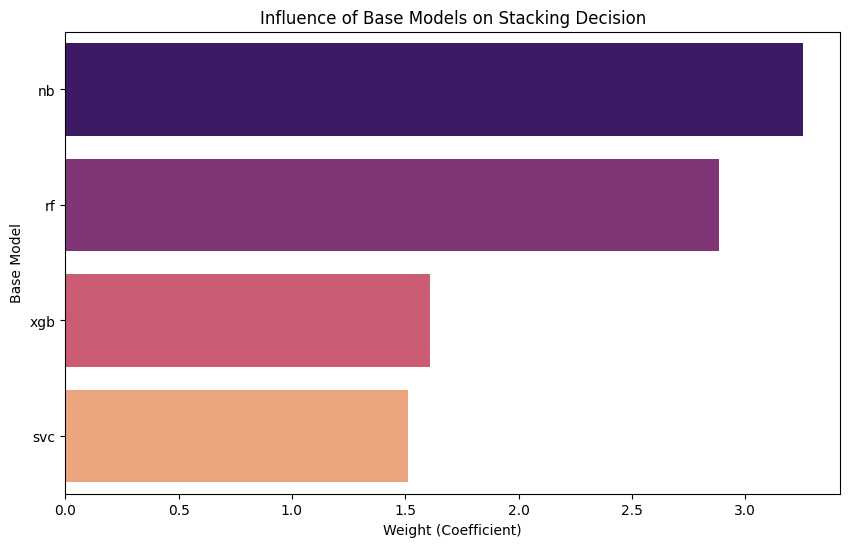

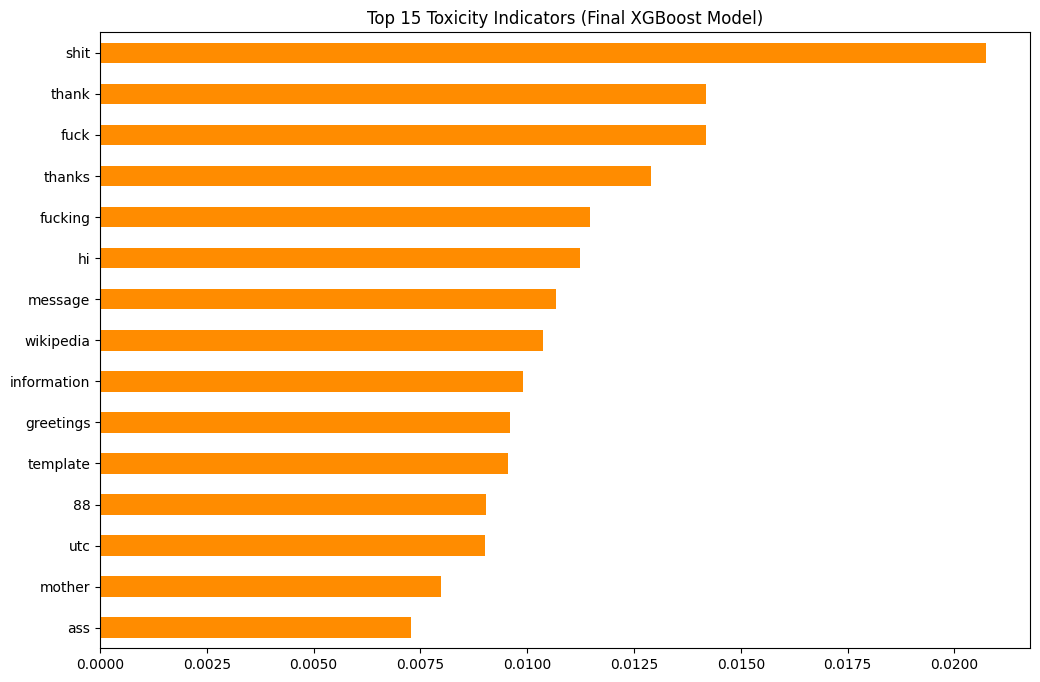

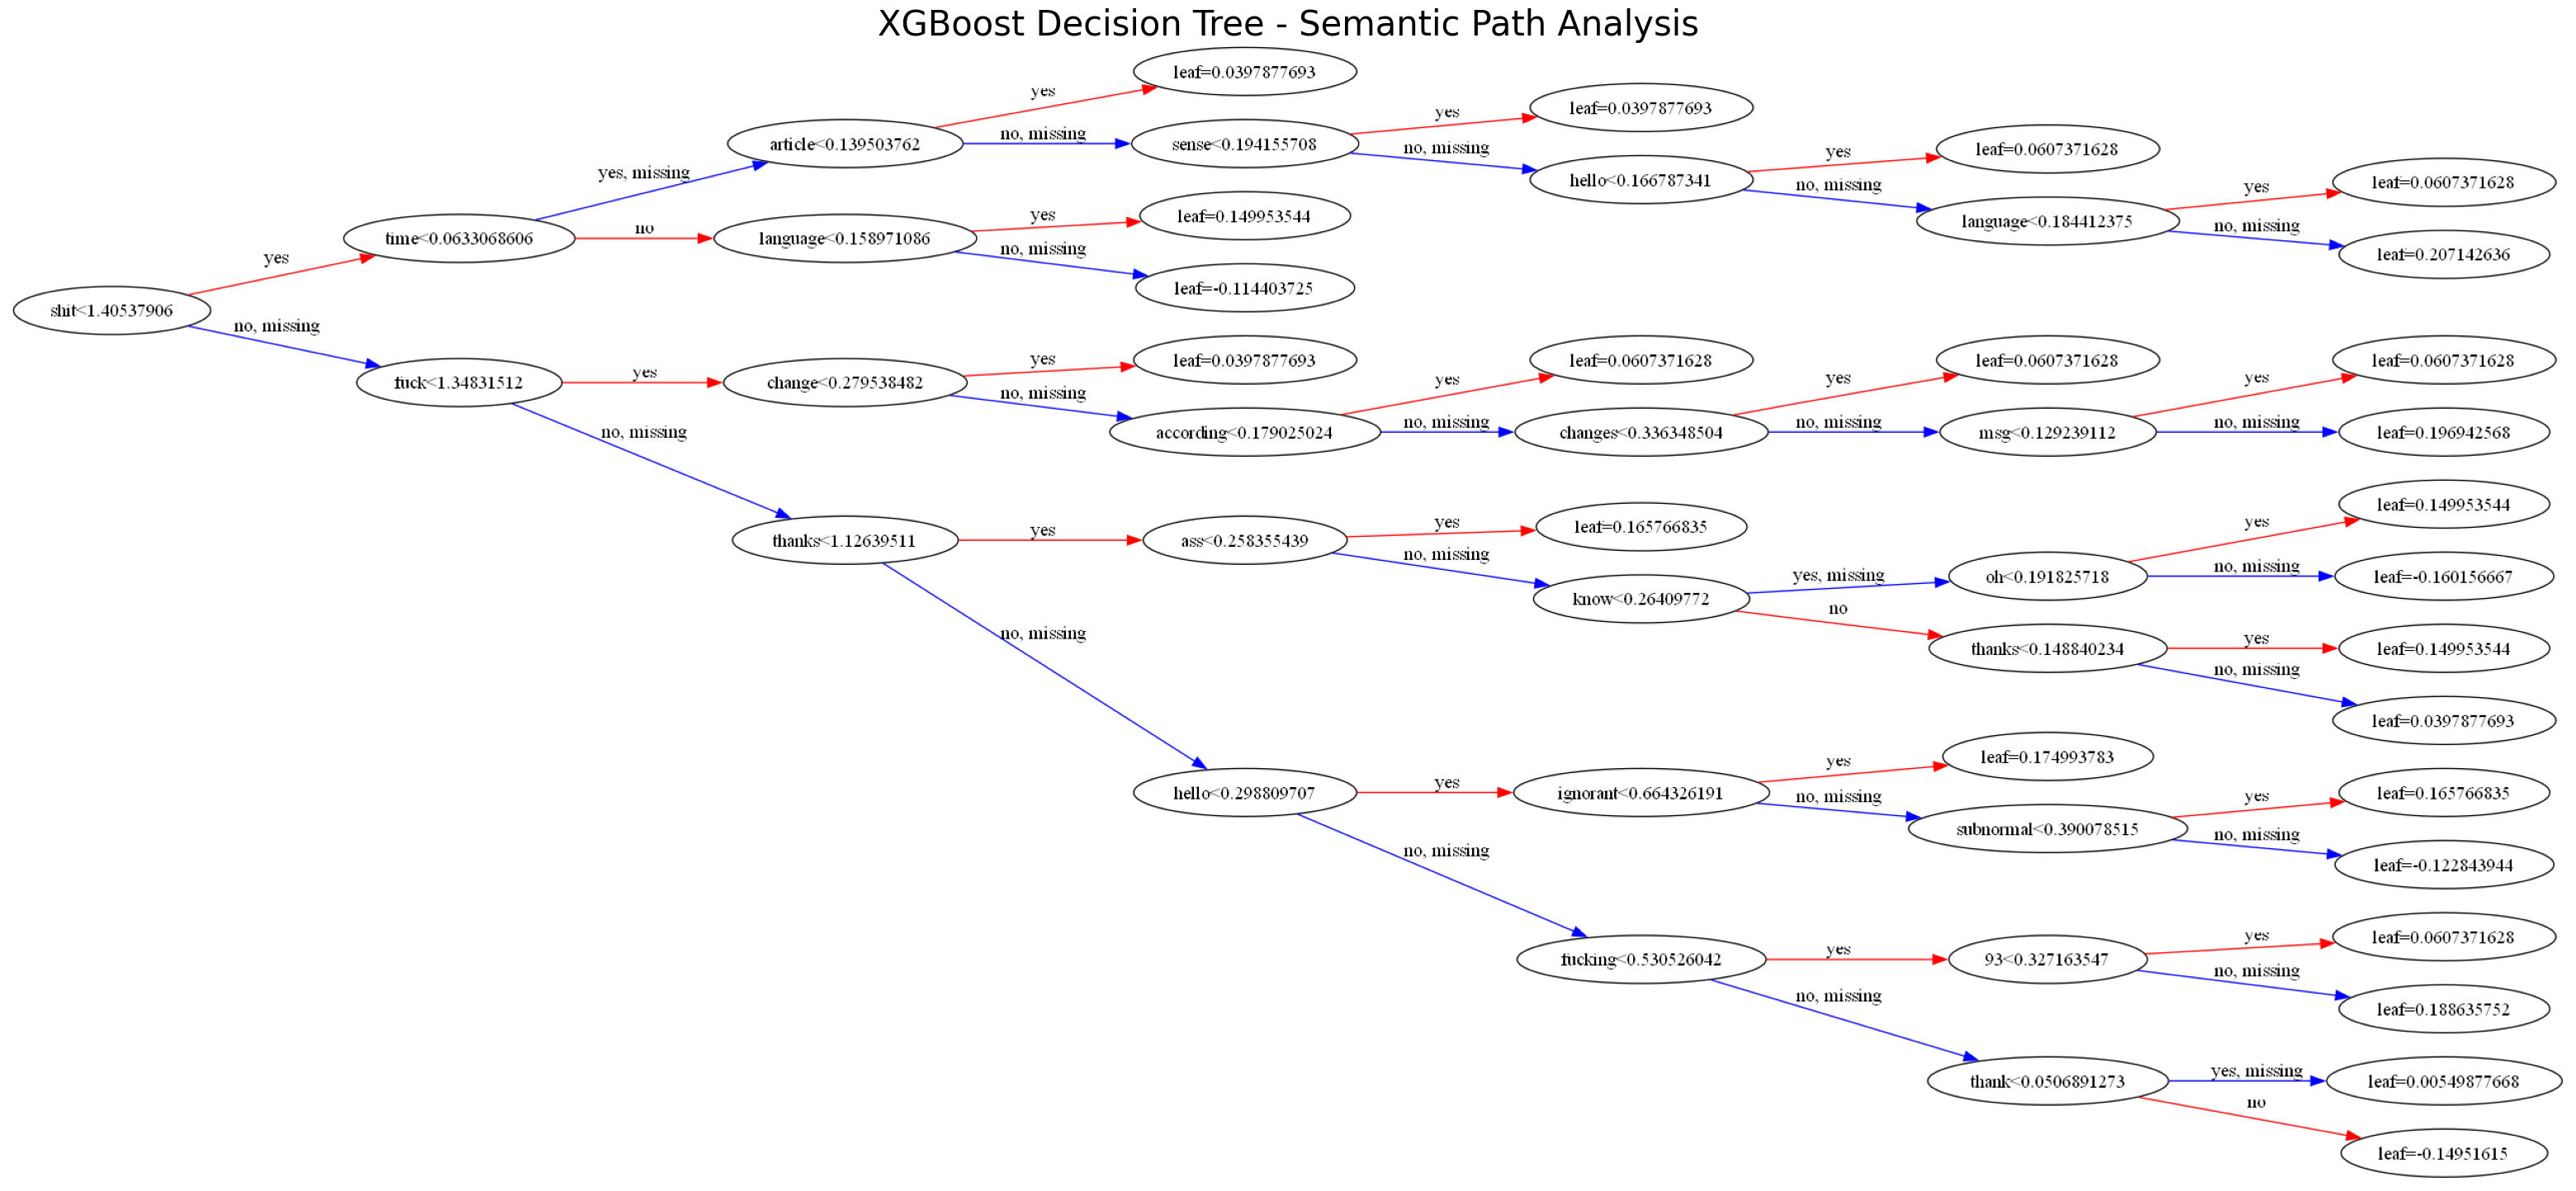

In [12]:
# --- 6α. Meta-Learner Analysis ---
print(f"\n{'='*20} Meta-Learner Weights Analysis {'='*20}")
# Παίρνουμε τους συντελεστές από την Logistic Regression (final_estimator)
meta_learner = stack_model.final_estimator_
coefs = meta_learner.coef_[0]
base_model_names = [name for name, _ in estimators]

meta_importance = pd.DataFrame({
    'Base Model': base_model_names,
    'Weight (Coefficient)': coefs
}).sort_values(by='Weight (Coefficient)', ascending=False)

print(meta_importance)

# Οπτικοποίηση των Meta-Weights
plt.figure(figsize=(10, 6))
sns.barplot(data=meta_importance, x='Weight (Coefficient)', y='Base Model', palette='magma')
plt.title('Influence of Base Models on Stacking Decision')
plt.show()

# --- 6β. Final Feature Importance (XGBoost) ---
# Χρησιμοποιούμε το μοντέλο από το xgb_grid που ορίσαμε στο Section 4
plt.figure(figsize=(12, 8))
xgb_final = xgb_grid.best_estimator_
xgb_imp = pd.Series(xgb_final.feature_importances_, index=tfidf.get_feature_names_out()).sort_values(ascending=False).head(15)
xgb_imp.plot(kind='barh', color='darkorange').invert_yaxis()
plt.title('Top 15 Toxicity Indicators (Final XGBoost Model)')
plt.show()

# --- 6γ. XGBoost Decision Tree Visualization ---
# Αντιστοίχιση των features με τις λέξεις του TF-IDF
xgb_final.get_booster().feature_names = list(tfidf.get_feature_names_out())



fig, ax = plt.subplots(figsize=(40, 20))
# Οπτικοποίηση του πρώτου δέντρου (num_trees=0) που είναι το πιο καθοριστικό
xgb.plot_tree(xgb_final, num_trees=0, rankdir='LR', ax=ax)
plt.title("XGBoost Decision Tree - Semantic Path Analysis", fontsize=30)
plt.show()